In [96]:
%matplotlib notebook
import numpy
import scipy
import scipy.interpolate
import copy

import matplotlib.colors as colors

/Users/kyunghyuncho/Library/Python/2.7/lib/python/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import multiprocessing

In [3]:
import matplotlib.pyplot as plot

In [4]:
filename = 'grs1915_all_125ms.dat'

In [14]:
data_original = numpy.load(filename)
data = data_original

In [15]:
n_samples = len(data)
print '# of samples:', n_samples

# of samples: 2829


In [16]:
labelled = [dd[1] is not None for dd in data]
print '# of labelled samples:', numpy.sum(labelled)

# of labelled samples: 426


In [17]:
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = numpy.arange(A.shape[0])
    good = numpy.where(numpy.isfinite(A))
    f = scipy.interpolate.interp1d(inds[good], A[good],bounds_error=False, fill_value='extrapolate')
    B = numpy.where(numpy.isfinite(A),A,f(inds))
    return B


In [18]:
# replace NaN with 0's for now.
data_original = copy.deepcopy(data)
data = [None] * n_samples
for idx, dd in enumerate(data_original):
    x = dd[0]
    if x.shape[0] > 2:
        y = 0. * x
        for ii in xrange(x.shape[1]):
            y[:, ii] = fill_nan(x[:,ii])
        if numpy.sum(numpy.isnan(y)) > 0:
            print 'problem at ', idx
            break
    else:
        y = x
    data[idx] = (y, dd[1])


/Users/kyunghyuncho/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


In [19]:
print fill_nan(x[:,0])

[  3.10431840e+08   3.10431840e+08   3.10431840e+08 ...,   3.10434560e+08
   3.10434560e+08   3.10434560e+08]


In [20]:
# simple normalization
data_n = [None] * n_samples
for idx, dd in enumerate(data):
    m = dd[0].mean(axis=0)
    s = dd[0].std(axis=0)
    dn = (dd[0] - m)/numpy.max(s, 1e-8)
    data_n[idx] = (dn, dd[1])

/Users/kyunghyuncho/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [21]:
idx = 10

plot.hold('on')
for varidx in xrange(data_n[idx][0].shape[1]):
    plot.plot(data_n[idx][0][:,varidx])
plot.hold('off')
plot.show()

In [22]:
dd[0][:,4]

array([ 424.,  352.,  352., ...,  520.,  504.,  456.])

In [23]:
def do_fft(dd):
    fftc = numpy.fft.fft(dd[0], axis=0)
    return (fftc, dd[1])

In [24]:
pool = multiprocessing.Pool(6)
fft_coeffs = pool.map(do_fft, data)

In [25]:
numpy.save(filename+'.fft', fft_coeffs)

In [11]:
def compute_power(dd):
    return (numpy.absolute(dd[0]), dd[1])

In [ ]:
fft_powers = pool.map(compute_power, fft_coeffs)

In [26]:
len(fft_coeffs)

2829

In [83]:
band_max=10000

In [79]:
idx = 10

plot.hold('on')
for varidx in xrange(fft_coeffs[idx][0].shape[1]):
    ll = fft_coeffs[idx][0].shape[0]
    coeff = fft_coeffs[idx][0][:,varidx]
    freq = numpy.fft.fftfreq(len(coeff))
    plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
plot.hold('off')
plot.show()

In [75]:
freq.shape, coeff.shape

((24319,), (24319,))

In [84]:
fft_coeffs_filt = [(numpy.absolute(dd[0][:band_max,:]), dd[1]) for dd in fft_coeffs]
for idx, dd in enumerate(fft_coeffs_filt):
    if numpy.sum(numpy.isnan(dd[0])) > 0:
        print 'NaN detected at', idx
        break
    dd[0].resize(band_max, dd[0].shape[1])

In [85]:
print dd[0].shape, band_max

(10000, 5) 10000


In [91]:
fft_features = numpy.vstack([dd[0].flatten() for dd in fft_coeffs_filt])

KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca_model = PCA(n_components=50)
Y_pca = pca_model.fit_transform(fft_features)

model = TSNE(n_components=2, random_state=0)
Y_tsne = model.fit_transform(Y_pca)

In [88]:
Y.shape

(2829, 2)

In [89]:
labels = numpy.unique([dd[1] for dd in data_original])
label_dict = dict([(dd,ii) for ii, dd in enumerate(labels)])

<IPython.core.display.Javascript object>


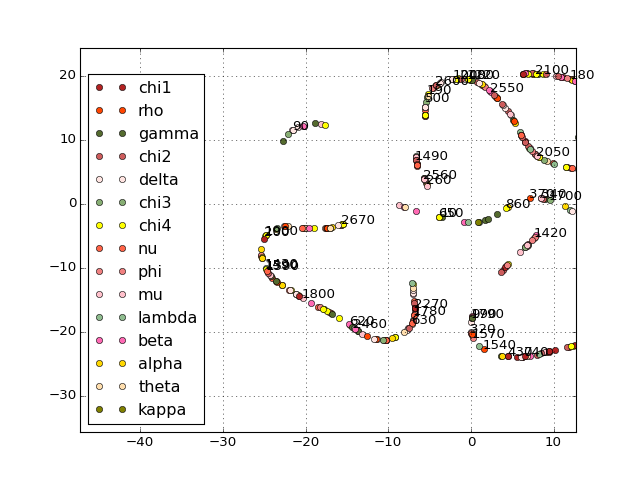

In [128]:
plot.figure()
clist = colors.cnames.values()

Y = Y_tsne
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
    #    plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
        if numpy.mod(idx, every) == 0:
            plot.annotate(xy=(Y[idx,0], Y[idx,1]), s=idx)

plot.hold('off')
plot.legend(legend_handles, legends, loc="lower left")
plot.grid('on')

plot.show()

<IPython.core.display.Javascript object>


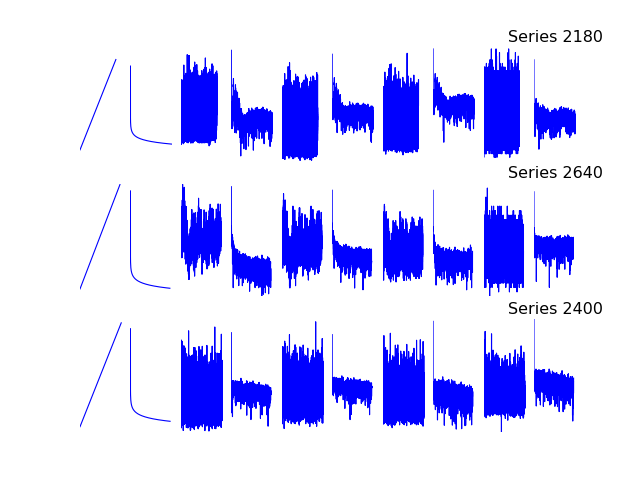

In [123]:
interesting = [2180, 2640, 2400]
band_max=1000

plot.figure()
for idx, ii in enumerate(interesting):
    series = data_original[ii][0]
    for sidx in xrange(series.shape[1]):
        plot.subplot(len(interesting), 5*2, idx*(5*2)+(2*sidx)+1)
        plot.plot(series[:,sidx])
        plot.axis('off')
        
        plot.subplot(len(interesting), 5*2, idx*(5*2)+(2*sidx)+2)
        ll = fft_coeffs[ii][0].shape[0]
        coeff = fft_coeffs[ii][0][:,sidx]
        freq = numpy.fft.fftfreq(len(coeff))
        plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
        plot.axis('off')
    plot.title('Series %d'%ii)
